<a href="https://www.kaggle.com/code/septianbagussantoso/tugas-machine-learning-ds-unsw-nb15-kelompok-8?scriptVersionId=244707765" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW_NB15_testing-set.csv
/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW-NB15_1.csv
/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW_NB15_training-set.csv
/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW-NB15_LIST_EVENTS.csv
/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW-NB15_4.csv
/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW-NB15_3.csv
/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW-NB15_2.csv
/kaggle/input/tugas-machine-learning-ds-unsw-nb15/NUSW-NB15_features.csv


In [2]:
# === IMPORT LIBRARY ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

2025-06-10 13:34:11.394669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749562451.692575      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749562451.772931      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# === LOAD DATA (HANYA TRAINING SET) ===
train_path = "/kaggle/input/tugas-machine-learning-ds-unsw-nb15/UNSW_NB15_training-set.csv"
df = pd.read_csv(train_path)

In [4]:
# === SPLIT FITUR & LABEL ===
X = df.drop(columns=["label", "attack_cat"])
y = df["label"]

In [5]:
# === ENCODING FITUR KATEGORIK ===
categorical_columns = X.select_dtypes(include=["object"]).columns
encoders = {}

for col in categorical_columns:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col].astype(str))
    encoders[col] = encoder

In [6]:
# === NORMALISASI ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# === SPLIT TRAIN / TEST ===
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# === SPLIT TRAIN / VALIDASI DARI TRAIN_ALL ===
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.2, random_state=42, stratify=y_train_all
)

In [9]:
# === DATA BINARISASI UNTUK BERNOULLI NB ===
median_vals = np.median(X_train, axis=0)
X_train_bin = (X_train > median_vals).astype(int)
X_val_bin = (X_val > median_vals).astype(int)
X_test_bin = (X_test > median_vals).astype(int)

In [10]:
# === INISIALISASI MODEL ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Support Vector Machine": SVC(probability=True),
    "Naïve Bayes": BernoulliNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Extreme Gradient Boosting": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Stochastic Gradient Descent": SGDClassifier(),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

In [11]:
# === CNN DENGAN DROPOUT, L2 REGULASI, DAN LAYER TAMBAHAN ===
def create_optimized_cnn(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,),
              kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_optimized_cnn(X_train.shape[1])
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100, batch_size=64, verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-10 13:34:30.751598: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8893 - loss: 0.4890 - val_accuracy: 0.9636 - val_loss: 0.1952
Epoch 2/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9620 - loss: 0.1859 - val_accuracy: 0.9718 - val_loss: 0.1325
Epoch 3/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9715 - loss: 0.1342 - val_accuracy: 0.9863 - val_loss: 0.0972
Epoch 4/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9792 - loss: 0.1081 - val_accuracy: 0.9897 - val_loss: 0.0812
Epoch 5/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9845 - loss: 0.0907 - val_accuracy: 0.9815 - val_loss: 0.0940
Epoch 6/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9836 - loss: 0.0887 - val_accuracy: 0.9930 - val_loss: 0.0646
Epoch 7/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9862 - loss: 0.0818 - val_accuracy: 0.9902 - val_loss: 0.0675
Epoch 8/100
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9861 - loss: 0.0811 - val_accu

In [12]:
# List untuk menyimpan hasil evaluasi
val_results = []
test_results = []

print("\n\U0001F4CB Detail Evaluasi Model Klasik:")
for name, model in models.items():
    print(f"Training {name}...")
    if name == "Naïve Bayes":
        model.fit(X_train_bin, y_train)
        y_val_pred = model.predict(X_val_bin)
        y_test_pred = model.predict(X_test_bin)
        y_val_proba = model.predict_proba(X_val_bin)[:, 1]
        y_test_proba = model.predict_proba(X_test_bin)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        y_val_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else y_val_pred
        y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_test_pred

    val_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_val, y_val_pred),
        "Precision": precision_score(y_val, y_val_pred),
        "Recall": recall_score(y_val, y_val_pred),
        "F1-Score": f1_score(y_val, y_val_pred),
        "AUC": roc_auc_score(y_val, y_val_proba),
        "Loss": 1 - accuracy_score(y_val, y_val_pred)
    })

    test_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1-Score": f1_score(y_test, y_test_pred),
        "AUC": roc_auc_score(y_test, y_test_proba),
        "Loss": 1 - accuracy_score(y_test, y_test_pred)
    })


📋 Detail Evaluasi Model Klasik:
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Support Vector Machine...
Training Naïve Bayes...
Training K-Nearest Neighbors...
Training AdaBoost...
Training Extreme Gradient Boosting...
Training Linear Discriminant Analysis...
Training Stochastic Gradient Descent...
Training Neural Network (MLP)...


In [13]:
# === Evaluasi CNN ===
y_val_pred_cnn = (cnn_model.predict(X_val) > 0.5).astype(int)
y_test_pred_cnn = (cnn_model.predict(X_test) > 0.5).astype(int)
y_val_proba_cnn = cnn_model.predict(X_val).flatten()
y_test_proba_cnn = cnn_model.predict(X_test).flatten()

val_results.append({
    "Model": "CNN",
    "Accuracy": accuracy_score(y_val, y_val_pred_cnn),
    "Precision": precision_score(y_val, y_val_pred_cnn),
    "Recall": recall_score(y_val, y_val_pred_cnn),
    "F1-Score": f1_score(y_val, y_val_pred_cnn),
    "AUC": roc_auc_score(y_val, y_val_proba_cnn),
    "Loss": 1 - accuracy_score(y_val, y_val_pred_cnn)
})

test_results.append({
    "Model": "CNN",
    "Accuracy": accuracy_score(y_test, y_test_pred_cnn),
    "Precision": precision_score(y_test, y_test_pred_cnn),
    "Recall": recall_score(y_test, y_test_pred_cnn),
    "F1-Score": f1_score(y_test, y_test_pred_cnn),
    "AUC": roc_auc_score(y_test, y_test_proba_cnn),
    "Loss": 1 - accuracy_score(y_test, y_test_pred_cnn)
})

412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [14]:
# === KONVERSI KE DATAFRAME ===
val_df = pd.DataFrame(val_results)
test_df = pd.DataFrame(test_results)

In [15]:
# === CETAK TABEL ===
print("\n\U0001F4CB Validation Set Metrics:")
print(val_df.round(4))
print("\n\U0001F4CB Test Set Metrics:")
print(test_df.round(4))


📋 Validation Set Metrics:
                           Model  Accuracy  Precision  Recall  F1-Score  \
0            Logistic Regression    0.9504     0.9501  0.9603    0.9552   
1                  Decision Tree    0.9995     0.9996  0.9996    0.9996   
2                  Random Forest    0.9990     0.9986  0.9996    0.9991   
3         Support Vector Machine    0.9702     0.9600  0.9869    0.9733   
4                    Naïve Bayes    0.6878     0.7437  0.6606    0.6997   
5            K-Nearest Neighbors    0.9768     0.9818  0.9760    0.9789   
6                       AdaBoost    1.0000     1.0000  1.0000    1.0000   
7      Extreme Gradient Boosting    0.9994     0.9996  0.9993    0.9994   
8   Linear Discriminant Analysis    0.9232     0.9262  0.9349    0.9306   
9    Stochastic Gradient Descent    0.9550     0.9483  0.9712    0.9596   
10          Neural Network (MLP)    0.9977     0.9981  0.9978    0.9979   
11                           CNN    0.9928     0.9922  0.9948    0.9935  

/tmp/ipykernel_13/8888350.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


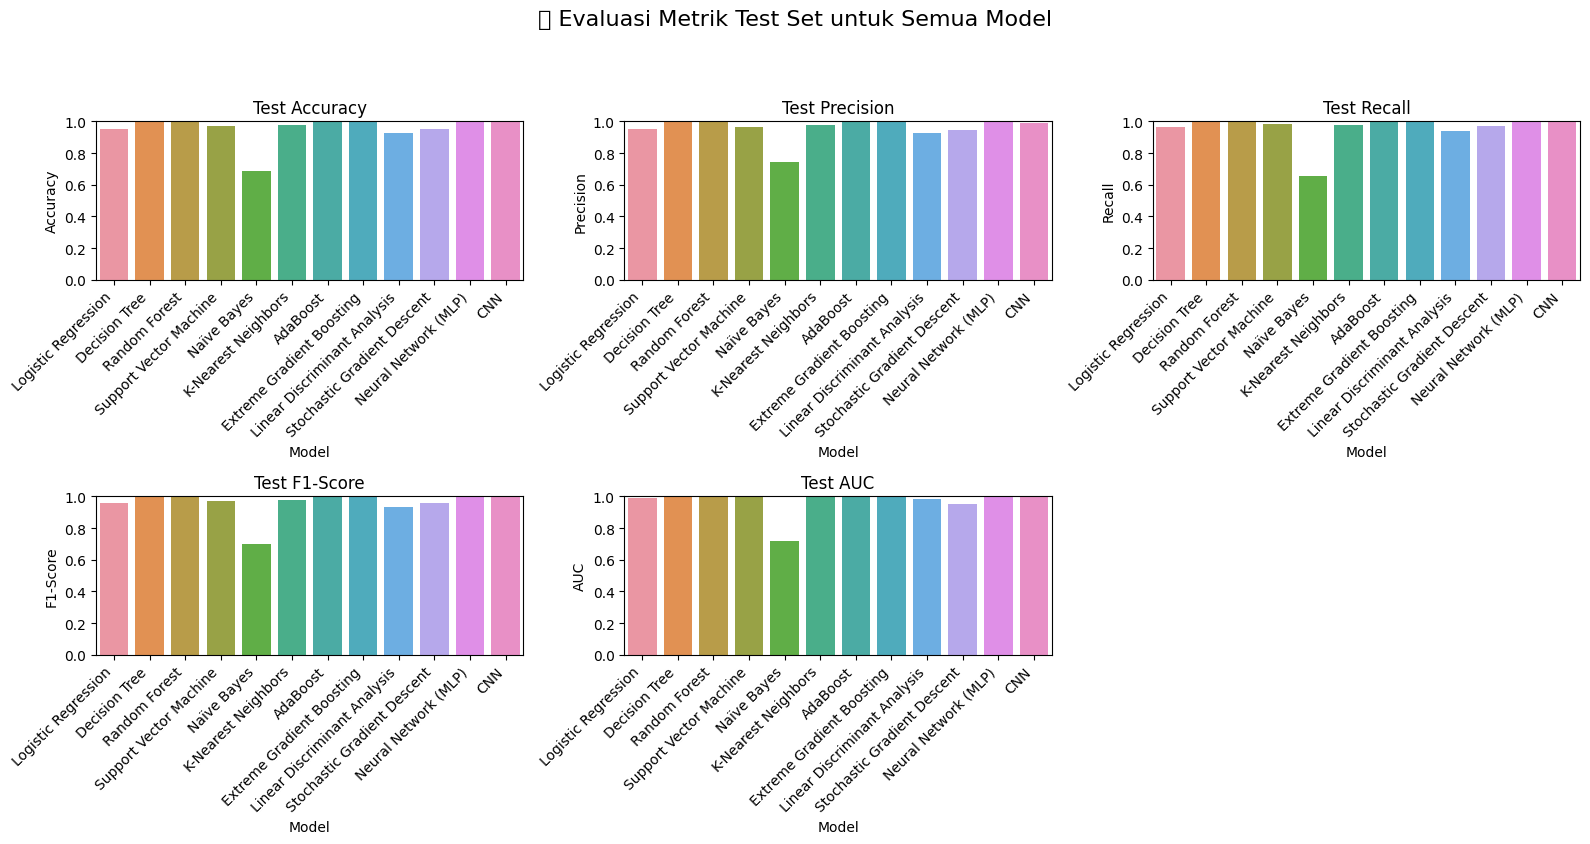

In [16]:
# === VISUALISASI METRIK TEST ===
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
plt.figure(figsize=(16, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=test_df, x="Model", y=metric)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Test {metric}")
    plt.ylim(0, 1)
    plt.tight_layout()

plt.suptitle("\U0001F4CA Evaluasi Metrik Test Set untuk Semua Model", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

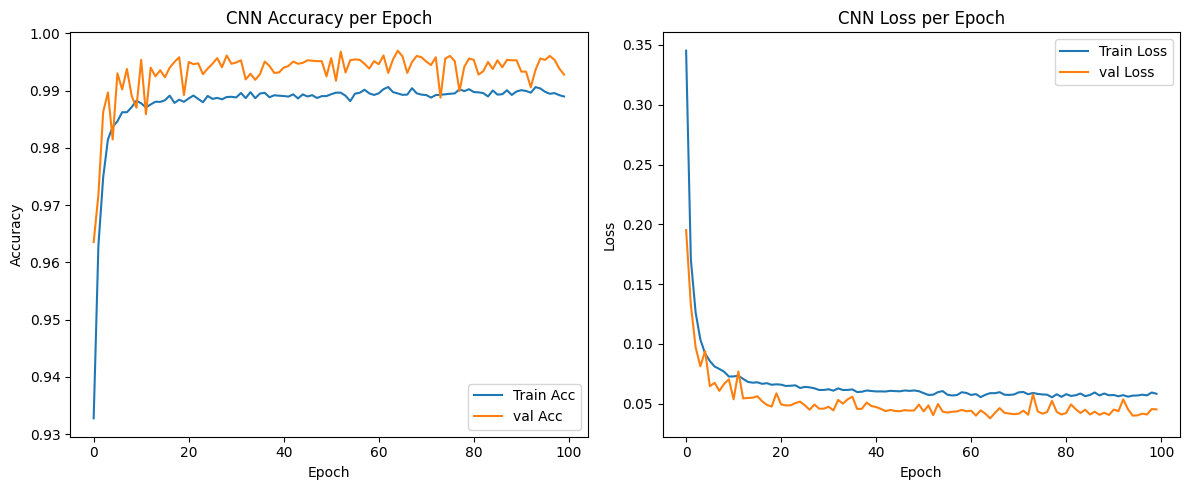

In [17]:
# === GRAFIK HISTORI TRAINING CNN ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='val Acc')
plt.title('CNN Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='val Loss')
plt.title('CNN Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()